# Starters

## Imports

In [5]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.measure
from PIL import Image
import re
import time
from skimage.io import imsave, imread
# from skimage.util import img_as_ubyte
from scipy import ndimage
# import deepcell
# import deepcell.applications.cell_tracking
# from deepcell.applications import Mesmer
from skimage import (
    color, data, color, io, filters, measure, morphology, segmentation, util
)
import math
import copy
import glob
import colorcet as cc
import plotly.io
import plotly.express as px
from collections import Counter

## Checking Versions and Conda Env

In [6]:
import matplotlib

print(matplotlib.__version__)
print(matplotlib.__file__)


3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


## Switches and Constants

In [7]:
# For saving the images from interpolations
saveimgs = False
saveimgs = True

# For saving new figures from the runs and the plotting
savefigs = False
savefigs = True

## Define Functions

In [8]:
def sort_nicely( l ):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

def showtif(file, zstack=0, channel=0, verbose = False):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack,channel]
    if verbose==True:
        if len(skimg.shape) == 2:
            print(skimg.shape,"\n", "Single layer of size {} x {}".format(skimg.shape[0],skimg.shape[1]))
        else:
            print(skimg.shape,"\n", "Showing Z-stack {} of {}".format(zstack+1, skimg.shape[0]))
    plt.axis('off')
    a = plt.imshow(img,cmap='gray')
    return a

# Function for returning values from dictionary keys
def get_key(dict,val):
    if type(val)==float:
        for key, value in dict.items():
            if val == value:
                return key
        return "key doesn't exist"
    if type(val)==list:
        outkeys = []
        for i in val:
            for key, value in dict.items():
                if i == value:
                    outkeys.append(key)
        return outkeys

# Bring in Data

## Set Directories

In [9]:
try:
    os.chdir(SCRIPTDIR)
except:
    SCRIPTDIR = os.path.realpath('./')
# SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'

os.chdir(SCRIPTDIR)
os.chdir('../inputs/train3D/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/cell_tracking/validating')
OUTDIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/cell_tracking/validating/figures')
FIGDIR = os.getcwd()


## Create Reference Dataframe

In [10]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

# Create reference df for all images
imgdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
imgdf['gappath'] = ''
imgdf['imagepath'] = ''
imgdf['labelpath'] = ''
imgdf['zlayers'] = ''
imgdf['x'] = ''
imgdf['y'] = ''

for index, row in imgdf.iterrows():
    indir = os.path.join(DATADIR, imgdf.iloc[index]['imgfolder'])
    imgdf.at[index, 'gappath'] = os.path.join(indir, 'gap.tif')
    imgdf.at[index, 'imagepath'] = os.path.join(indir, 'image.tif')
    imgdf.at[index, 'labelpath'] = os.path.join(indir, 'label.tif')
    im = imgdf['imagepath'][0]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index, 'zlayers'] = skimg.shape[0]
    imgdf.at[index, 'x'] = skimg.shape[1]
    imgdf.at[index, 'y'] = skimg.shape[2]
# imgdf

## Bring in Original Functions

In [11]:
# Original input image dictionary creator from single image
def CreateLabelDictv01(inputimg):
    # Check if the object passed is a in image or a file
    if os.path.isfile(inputimg):
        zstack = io.imread(inputimg, plugin='tifffile')
    else:
        zstack = inputimg
    origdict={}
    labdict={}
    imgdict={}
    dfdict={}
    for i in range(zstack.shape[0]):
        singlez = zstack[i]
        labeled = measure.label(singlez)
        props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
        propframe = pd.DataFrame(props)
        slicename = 'z'+str(i)
        dfdict[slicename]=propframe
        imgdict[slicename]=singlez
        labdict[slicename]=labeled
    origdict["images"]=imgdict
    origdict["labels"]=labdict
    origdict["props"]=dfdict
    return origdict

# Image creator: Creates a dictionary of the z-stacks of label image that are colored, numbered, and shaded based on updated labels.
def StackCreatorv01(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all of the label images.
    uniquelabs = []
    for i in input_dict['props'].keys():
        for j in np.unique(input_dict['props'][i].label):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)
    # Create the color map for all of the unique labels.
    randcols = np.random.random((len(uniquelabs), 3))
    # Set background labels as 0
    randcols[0] = 0

    # Create a stack of the colored labels
    coloredlabels = []
    for i in input_dict['labels']:
        # Need to label the image, then create a numpy array from that plot.
        # Bizzare figsize and DPI declarations come from plt's method of creating figures, this ensures that the resulting numpy array has the same dimensions as the input image.
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        labz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        labz = labz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        coloredlabels.append(labz)
        plt.close(fig)
    coloredstack = np.stack(coloredlabels)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['images']:
        xsize = input_dict['images'][h].shape[0]/100
        ysize = input_dict['images'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['images'][i].shape[0]/100
        ysize = input_dict['images'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=coloredstack
    stackdict['numbered']=numberedstack
    return stackdict

# Save or create a gif from any image stack.
def OutputWriterv01(input_stack, output_name, output_directory, savegif = True, savetiff = True):
    if savegif:
        filenames = []
        for i in range(input_stack.shape[0]):
            fig, ax = plt.subplots(figsize=(10,10))
            ax.imshow(input_stack[i])
            ax.axis('off')
            plt.tight_layout(pad=0)

            filename = os.path.join(output_directory, f'temp_{i}.tiff')
            filenames.append(filename)
            plt.savefig(filename)
            plt.close(fig)
        # Create the GIF from the saved images.
        fp_in = os.path.join(output_directory,"temp_*.tiff")
        fp_out = os.path.join(output_directory,f"{output_name}.gif")
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)  # extract first image from iterator
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=200, loop=0)
        for filename in set(filenames):
            os.remove(filename)
    if savetiff:
        pilimages = []
        for i in range(input_stack.shape[0]):
            new = Image.fromarray(input_stack[i])
            pilimages.append(new)
        outname = os.path.join(output_directory,f"{output_name}.tiff")
        pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])


In [12]:
def CreateLabelDictv02(inputimg, reverse_direction = False):
    # Check if the object passed is a in image or a file
    if os.path.isfile(inputimg):
        zstack = io.imread(inputimg, plugin='tifffile')
    else:
        zstack = inputimg

    forward = [*range(zstack.shape[0])]
    reverse = forward.copy()
    reverse.reverse()
    if reverse_direction:
        direction = reverse
    else:
        direction = forward
    origdict={}
    labdict={}
    imgdict={}
    dfdict={}
    counter = 0
    for i in direction:
        singlez = zstack[i]
        labeled = measure.label(singlez)
        props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
        propframe = pd.DataFrame(props)
        slicename = 'z'+str(counter)
        dfdict[slicename]=propframe
        imgdict[slicename]=singlez
        labdict[slicename]=labeled
        counter += 1
    origdict["images"]=imgdict
    origdict["labels"]=labdict
    origdict["props"]=dfdict
    return origdict

In [13]:
def CellTrackerv03(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    forwardpass =[]
    for i in newdict['images'].keys():
        forwardpass.append(i)
    reversepass = forwardpass.copy()
    reversepass.reverse()

    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
            newdict['labels'][i][newdict['labels'][i]==j]=0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i]=newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            # concat = str(i)+"-"+str(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1])+1
        endz = 'z'+str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            # Doing this to exclude the background zeros but may be removing true labels when start labels are entirely within the boundaries of the end labels
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1])-1
        endz = 'z'+str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
    return newdict

In [14]:
def CellTrackerv04(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    # Set up a list to move through the images in reverse.
    forwardpass =[]
    for i in newdict['images'].keys():
        forwardpass.append(i)
    reversepass = forwardpass.copy()
    reversepass.reverse()

    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
            newdict['labels'][i][newdict['labels'][i]==j]=0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    for i in newdict['labels'].keys():
        remaininglabels = segmentation.clear_border(newdict['labels'][i], buffer_size=10)
        newdict['labels'][i] = remaininglabels
        remaininglabels = np.unique(remaininglabels)
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].label.isin(remaininglabels)]
        newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1])+1
        endz = 'z'+str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            # Explicitly removing non-zero values from list of overlapping labels instead of removing the label in the first position.
            overlapid = np.unique(overlappinglabels)
            overlapid = overlapid[overlapid!=0]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid

        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1])-1
        endz = 'z'+str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    # Check to make sure the labels and regionprops tables have same labels.
    uniquelabs=[]
    for i in newdict['labels'].keys():
        for j in np.unique(newdict['labels'][i]):
            uniquelabs.append(j)

    uniqueprops = []
    for i in newdict['props'].keys():
        for j in np.unique(newdict['props'][i].label):
            uniqueprops.append(j)

    # If they arent the same, remove the regionprops labels
    if len(np.unique(uniqueprops)+1) != len(np.unique(uniquelabs)):
        for q in newdict['props']:
            if sum(newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs)))>0:
                newdict['props'][q] = newdict['props'][q].drop(newdict['props'][q][newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs))].index)
                newdict['props'][q]=newdict['props'][q].reset_index(drop=True)



    # Move through the entire final z-stack and change the labels to a standardized number range.
    # Create and populate a dataframe consisting of every label across all layers in the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            if j not in uniqueid:
                uniqueid.append(j)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel

    # Step through each unique ID, locate and update the corresponding labels using the index position of the label (+1 to not overwrite bg pixels with value == 0)
    for ind, id in enumerate(uniqueid):
        new_id = ind+1
        old_id = id
        matchingidx = labids[labids['zlabel']==old_id].index.tolist()
        for j in matchingidx:
            zlayer = labids.iloc[j]['zlayer']
            zlabel = old_id
            corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
            newdict['props'][zlayer].at[corridx,'label']=new_id
            newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id

    return newdict

In [15]:
def StackCreatorv02(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all the label images.
    uniquelabs = []
    for i in input_dict['labels'].keys():
        for j in np.unique(input_dict['labels'][i]):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)

    # Create the color map for all of the unique labels.
    pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
    # Set background labels as 0
    pal[0] = '#000000'

    hexdict = {}
    for idx,hex in enumerate(pal):
        hexdict[idx]=hex

    newstack = []
    for i in input_dict['labels']:
        newstack.append(input_dict['labels'][i])
    imtoshow = np.stack(newstack)

    rgbdict = {}
    for col in hexdict.keys():
        rgbdict[col]=matplotlib.colors.hex2color(hexdict[col])

    hstacks = []
    for val in rgbdict.values():
        hstacks.append(np.hstack(val))
    rgbstacks = np.stack(hstacks)

    r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

    for idx,red in enumerate(rgbstacks[:,0]):
        r = np.where(imtoshow==idx, red,r)
    for idx,green in enumerate(rgbstacks[:,1]):
        g = np.where(imtoshow==idx, green,g)
    for idx,blue in enumerate(rgbstacks[:,2]):
        b = np.where(imtoshow==idx, blue,b)

    fullrgbim = np.stack((r,g,b), axis=3)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['labels']:
        xsize = input_dict['labels'][h].shape[0]/100
        ysize = input_dict['labels'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=fullrgbim
    stackdict['numbered']=numberedstack
    return stackdict

# Reversing Stack

## First Pass
- Reversing the z-stack at the level of cell tracking
- Breaking the functions into forward and reverse

### Create Functions

In [16]:
def ForwardCellTrackerv03(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    forwardpass =[]
    for i in newdict['images'].keys():
        forwardpass.append(i)
    reversepass = forwardpass.copy()
    reversepass.reverse()

    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
            newdict['labels'][i][newdict['labels'][i]==j]=0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i]=newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            # concat = str(i)+"-"+str(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1])+1
        endz = 'z'+str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            # Doing this to exclude the background zeros but may be removing true labels when start labels are entirely within the boundaries of the end labels
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1])-1
        endz = 'z'+str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
    return newdict

In [17]:
def ReverseCellTrackerv03(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    reversepass = []
    for i in newdict['images'].keys():
        reversepass.append(i)
    forwardpass = reversepass.copy()
    forwardpass.reverse()
    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area < 50]['label']:
            newdict['labels'][i][newdict['labels'][i] == j] = 0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area > 50]
        newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            # concat = str(i)+"-"+str(j)
            counter += 1
            uniqueid.append(counter)
    labids['zlayer'] = zlayers
    labids['zlabel'] = zlabel
    labids['uid'] = uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label == zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx, 'label'] = uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer] == zlabel] = uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1]) + 1
        endz = 'z' + str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1, 'endzoverlaps', 0)
        labchangedf.insert(2, 'action', "none")
        labchangedf['endzoverlaps'] = labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel = i
            startbinarray = newdict['labels'][startz] == speclabel
            overlappinglabels = startbinarray * newdict['labels'][endz]
            # Doing this to exclude the background zeros but may be removing true labels when start labels are entirely within the boundaries of the end labels
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels'] == i].tolist()[0]
            labchangedf.at[labelindex, "endzoverlaps"] = overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps']) == 0:
                labchangedf.at[i, 'action'] = 'shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps']) == 1:
                labchangedf.at[i, 'action'] = 'update'
            if len(labchangedf.iloc[i]['endzoverlaps']) > 1:
                labchangedf.at[i, 'action'] = 'branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action'] != 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz] == startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz] == j
                endarea = newdict['props'][endz][newdict['props'][endz]['label'] == j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin, endbin))
                percentoverlap = (overlap / endarea).tolist()
                if (percentoverlap[0]) > 0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i, "endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps']) == 0:
                labchangedf.at[i, 'action'] = 'shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps']) == 1:
                labchangedf.at[i, 'action'] = 'update'
            if len(labchangedf.iloc[i]['endzoverlaps']) > 1:
                labchangedf.at[i, 'action'] = 'branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action'] == 'shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label'] == j].index.tolist()[0]
                newdict['props'][endz].at[origind, 'label'] = newlabel
                newdict['labels'][endz][newdict['labels'][endz] == origlabel] = newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1]) - 1
        endz = 'z' + str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1, 'endzoverlaps', 0)
        labchangedf.insert(2, 'action', "none")
        labchangedf['endzoverlaps'] = labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel = i
            startbinarray = newdict['labels'][startz] == speclabel
            overlappinglabels = startbinarray * newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels'] == i].tolist()[0]
            labchangedf.at[labelindex, "endzoverlaps"] = overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps']) == 0:
                labchangedf.at[i, 'action'] = 'shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps']) == 1:
                labchangedf.at[i, 'action'] = 'update'
            if len(labchangedf.iloc[i]['endzoverlaps']) > 1:
                labchangedf.at[i, 'action'] = 'branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action'] != 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz] == startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz] == j
                endarea = newdict['props'][endz][newdict['props'][endz]['label'] == j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin, endbin))
                percentoverlap = (overlap / endarea).tolist()
                if (percentoverlap[0]) > 0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i, "endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps']) == 0:
                labchangedf.at[i, 'action'] = 'shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps']) == 1:
                labchangedf.at[i, 'action'] = 'update'
            if len(labchangedf.iloc[i]['endzoverlaps']) > 1:
                labchangedf.at[i, 'action'] = 'branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action'] == 'shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label'] == j].index.tolist()[0]
                newdict['props'][endz].at[origind, 'label'] = newlabel
                newdict['labels'][endz][newdict['labels'][endz] == origlabel] = newlabel
    return newdict

### Run on toy df

In [18]:
testgroup = imgdf.iloc[[0]].copy()
testgroup

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [19]:
# Loop to run single image through all
# runtest = False
# runtest = True
#
# df = testgroup
#
# start_time = time.time()
# if runtest:
#     for i in df.index:
#         imagename = df['imgfolder'][i]
#         labelimage = df['labelpath'][i]
#         origlabeldict = CreateLabelDictv01(labelimage)
#         newlabelsforward = ForwardCellTrackerv03(origlabeldict)
#         newlabelsreverse = ReverseCellTrackerv03(origlabeldict)
#
# print("--- %s seconds ---" % round((time.time() - start_time),0))

In [20]:
# print('Forward keys:',newlabelsforward['labels'].keys())
# print('Reverse keys:', newlabelsreverse['labels'].keys())
# # reversepass

In [21]:
# ztoshow = 'z'+str(2)
#
# fig, ax = plt.subplots(1,2, figsize = (16,9))
# ax[0].axis('off')
# ax[1].axis('off')
# ax[0].imshow(newlabelsreverse['labels'][ztoshow], cmap='gray')
# ax[1].imshow(newlabelsforward['labels'][ztoshow], cmap='gray')

### Compare the two outputs

In [22]:
# forlabs = []
# for i in newlabelsforward['labels']:
#     for j in newlabelsforward['props'][i].label:
#         forlabs.append(j)
# forlabs = np.unique(forlabs)
#
# revlabs = []
# for i in newlabelsreverse['labels']:
#     for j in newlabelsreverse['props'][i].label:
#         revlabs.append(j)
# revlabs = np.unique(revlabs)
# # revlabs

In [23]:
# print(len(forlabs), len(revlabs))

## Second method of reversing stack
- Creating separate stacks at the dictionary level.
- Passing the two separate dictionaries to the same stack cell tracker function.
- Makes it easier to check the success, doesnt mess up cell tracking function.

### Testing

In [24]:
testgroup['labelpath'][0]

'/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_1/label.tif'

(7, 1024, 1024) 
 Showing Z-stack 1 of 7


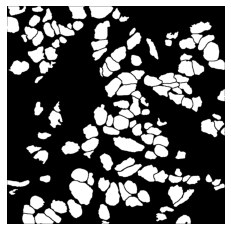

In [25]:
# CreateLabelDictv01 pulled out
inputimg = testgroup['labelpath'][0]

###
# def CreateLabelDictv01(inputimg):
# Check if the object passed is a in image or a file
if os.path.isfile(inputimg):
    zstack = io.imread(inputimg, plugin='tifffile')
else:
    zstack = inputimg
###

showtif(zstack,zstack=0, verbose = True)

In [26]:
# Original
###
origdict={}
labdict={}
imgdict={}
dfdict={}
for i in range(zstack.shape[0]):
    singlez = zstack[i]
    labeled = measure.label(singlez)
    props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
    propframe = pd.DataFrame(props)
    slicename = 'z'+str(i)
    dfdict[slicename]=propframe
    imgdict[slicename]=singlez
    labdict[slicename]=labeled
origdict["images"]=imgdict
origdict["labels"]=labdict
origdict["props"]=dfdict
# return origdict
###


### New Function at Top Level

In [27]:
# New One
# Needs to be added.
reverse_direction = True
reverse_direction = False
###
forward = [*range(zstack.shape[0])]
reverse = forward.copy()
reverse.reverse()
if reverse_direction:
    direction = reverse
else:
    direction = forward
origdict={}
labdict={}
imgdict={}
dfdict={}
counter = 0
for i in direction:
    singlez = zstack[i]
    labeled = measure.label(singlez)
    props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
    propframe = pd.DataFrame(props)
    slicename = 'z'+str(counter)
    dfdict[slicename]=propframe
    imgdict[slicename]=singlez
    labdict[slicename]=labeled
    # print(counter, i)
    counter += 1
origdict["images"]=imgdict
origdict["labels"]=labdict
origdict["props"]=dfdict
# return origdict
###

### Create Function

In [28]:
# Final Function
# def CreateLabelDictv02(inputimg, reverse_direction = False):
#     # Check if the object passed is a in image or a file
#     if os.path.isfile(inputimg):
#         zstack = io.imread(inputimg, plugin='tifffile')
#     else:
#         zstack = inputimg
#
#     forward = [*range(zstack.shape[0])]
#     reverse = forward.copy()
#     reverse.reverse()
#     if reverse_direction:
#         direction = reverse
#     else:
#         direction = forward
#     origdict={}
#     labdict={}
#     imgdict={}
#     dfdict={}
#     counter = 0
#     for i in direction:
#         singlez = zstack[i]
#         labeled = measure.label(singlez)
#         props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
#         propframe = pd.DataFrame(props)
#         slicename = 'z'+str(counter)
#         dfdict[slicename]=propframe
#         imgdict[slicename]=singlez
#         labdict[slicename]=labeled
#         counter += 1
#     origdict["images"]=imgdict
#     origdict["labels"]=labdict
#     origdict["props"]=dfdict
#     return origdict


### Test and Compare Function

In [29]:
inputimg = testgroup['labelpath'][0]

forwarddict = CreateLabelDictv02(inputimg)
reversedict = CreateLabelDictv02(inputimg,reverse_direction=True)

In [30]:
testgroup

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


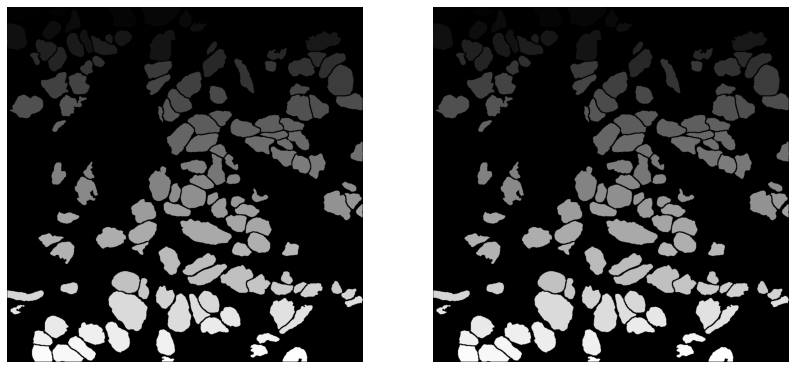

In [31]:
fig, ax = plt.subplots(1,2, figsize = (14,9))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(forwarddict['labels']['z0'], cmap='gray')
ax[1].imshow(reversedict['labels']['z6'], cmap='gray')

### Run on toy df

In [32]:
imgdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [33]:
testgroup = imgdf.iloc[[0]].copy()
testgroup

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [34]:
# Loop to run single image through all
runtest = False
runtest = True

df = testgroup

start_time = time.time()
if runtest:
    for i in df.index:
        imagename = df['imgfolder'][i]
        labelimage = df['labelpath'][i]
        forwardlabeldict = CreateLabelDictv02(labelimage)
        reverselabeldict = CreateLabelDictv02(labelimage, reverse_direction = True)
        newlabelsforward = CellTrackerv04(forwardlabeldict)
        newlabelsreverse = CellTrackerv04(reverselabeldict)

print("--- %s seconds ---" % round((time.time() - start_time),0))

--- 85.0 seconds ---


In [35]:
dftoqc = newlabelsforward

uniquelabs=[]
for i in dftoqc['labels'].keys():
    for j in np.unique(dftoqc['labels'][i]):
        uniquelabs.append(j)
print(len(np.unique(uniquelabs)), np.max(uniquelabs))

uniqueprops = []
for i in dftoqc['props'].keys():
    for j in np.unique(dftoqc['props'][i].label):
        uniqueprops.append(j)
print(len(np.unique(uniqueprops)), np.max(uniqueprops))

Counter(uniqueprops) == Counter([value for value in uniquelabs if value != 0])

122 121
121 121


True

In [36]:
print('Forward keys:',newlabelsforward['labels'].keys())
print('Reverse keys:', newlabelsreverse['labels'].keys())

Forward keys: dict_keys(['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6'])
Reverse keys: dict_keys(['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6'])


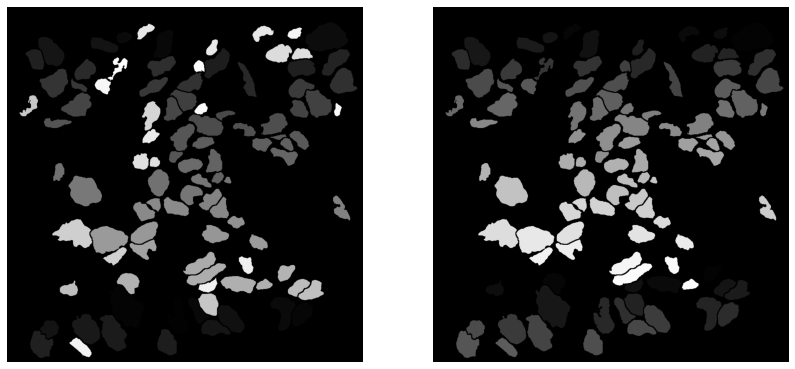

In [37]:
fig, ax = plt.subplots(1,2, figsize = (14,9))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(newlabelsforward['labels']['z6'], cmap='gray')
ax[1].imshow(newlabelsreverse['labels']['z0'], cmap='gray')

### Compare the two outputs

In [38]:
forlabs = []
for i in newlabelsforward['labels']:
    for j in newlabelsforward['props'][i].label:
        forlabs.append(j)
forlabs = np.unique(forlabs)

revlabs = []
for i in newlabelsreverse['labels']:
    for j in newlabelsreverse['props'][i].label:
        revlabs.append(j)
revlabs = np.unique(revlabs)
# revlabs

In [39]:
print(len(forlabs), len(revlabs))

121 112


## Make Gifs

In [40]:
print(testgroup.iloc[0]['imgfolder'])
testgroup.iloc[0]['imagepath']

C1-FB323A_CSC_Rd1_1


'/scratch/ns4964/lionnet/inputs/train3D/C1-FB323A_CSC_Rd1_1/image.tif'

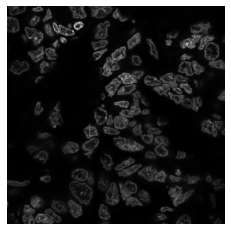

In [41]:
inputim = io.imread(testgroup.iloc[0]['imagepath'], plugin='tifffile')
showtif(inputim)

In [42]:
os.getcwd()

'/scratch/ns4964/lionnet/inputs/train3D'

In [43]:
savegif = True
savegif = False

input_stack = inputim
output_directory = '/scratch/ns4964/lionnet/output/cell_tracking/validating'
output_name = testgroup.iloc[0]['imgfolder'] + '_forward'
if savegif:
    filenames = []
    for i in range(input_stack.shape[0]):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(input_stack[i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)

        filename = os.path.join(output_directory, f'temp_{i}.tiff')
        filenames.append(filename)
        plt.savefig(filename)
        plt.close(fig)
    # Create the GIF from the saved images.
    fp_in = os.path.join(output_directory,"temp_*.tiff")
    fp_out = os.path.join(output_directory,f"{output_name}.gif")
    imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
    img = next(imgs)
    # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    for filename in set(filenames):
        os.remove(filename)


In [44]:
reversestack = StackCreatorv02(newlabelsreverse)

In [45]:
reversestack.keys()

dict_keys(['shaded', 'colored', 'numbered'])

In [46]:
savegif = True
savegif = False

input_stack = reversestack['colored']
output_directory = '/scratch/ns4964/lionnet/output/cell_tracking/validating'
output_name = testgroup.iloc[0]['imgfolder'] + '_colored_label_reverse'
if savegif:
    filenames = []
    for i in range(input_stack.shape[0]):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(input_stack[i])
        ax.axis('off')
        plt.tight_layout(pad=0)

        filename = os.path.join(output_directory, f'temp_{i}.tiff')
        filenames.append(filename)
        plt.savefig(filename)
        plt.close(fig)
    # Create the GIF from the saved images.
    fp_in = os.path.join(output_directory,"temp_*.tiff")
    fp_out = os.path.join(output_directory,f"{output_name}.gif")
    imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
    img = next(imgs)
    # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    for filename in set(filenames):
        os.remove(filename)

# Calculate Volumetric Readout

## Testing Pieces

In [47]:
# forims = StackCreatorv01(newlabelsforward)
# revims = StackCreatorv01(newlabelsreverse)

In [49]:
newstack = []
for i in newlabelsforward['labels']:
    newstack.append(newlabelsforward['labels'][i])
forims = np.stack(newstack)

newstack = []
for i in newlabelsforward['labels']:
    newstack.append(newlabelsreverse['labels'][i])
revims = np.stack(newstack)

np.shape(revims)

(7, 1024, 1024)

(7, 1024, 1024) 
 Showing Z-stack 1 of 7


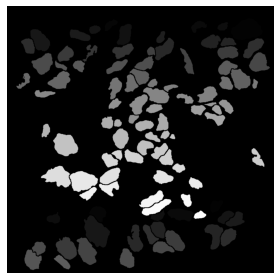

In [50]:
showtif(revims, verbose = True)
plt.tight_layout()

In [51]:
revprops = pd.DataFrame(measure.regionprops_table(revims, properties=('label','area', 'centroid','slice')))
forprops = pd.DataFrame(measure.regionprops_table(forims, properties=('label','area')))

In [52]:
revprops

,label,area,centroid-0,centroid-1,centroid-2,slice
0,1,49453,2.625463,218.758458,893.680808,"(slice(0, 7, None), slice(47, 801, None), slic..."
1,2,25785,3.023037,716.778204,351.697343,"(slice(0, 7, None), slice(51, 829, None), slic..."
2,3,42122,3.249941,731.517853,681.693747,"(slice(0, 7, None), slice(57, 830, None), slic..."
3,4,11086,2.588851,715.768898,265.540592,"(slice(0, 7, None), slice(62, 834, None), slic..."
4,5,30722,2.981837,188.077729,463.036130,"(slice(0, 7, None), slice(67, 828, None), slic..."
...,...,...,...,...,...,...
107,108,4199,5.589188,838.247678,453.290069,"(slice(5, 7, None), slice(804, 871, None), sli..."
108,109,1629,5.546961,828.687538,983.339472,"(slice(5, 7, None), slice(813, 847, None), sli..."
109,110,3086,5.424498,991.289047,719.982502,"(slice(5, 7, None), slice(972, 1013, None), sl..."
110,111,589,6.000000,119.984720,589.137521,"(slice(6, 7, None), slice(102, 140, None), sli..."


## Explore Plots

Text(0.5, 1.0, 'Histogram of Cells by Volume')

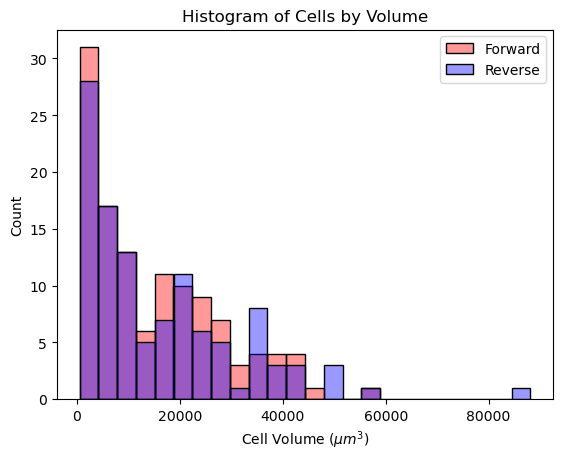

In [54]:
plt.style.use('default')
sns.histplot(x='area', data = forprops, color = 'red', bins = 16, alpha = 0.4, label='Forward')
sns.histplot(x='area', data = revprops, color = 'blue', bins = 24, alpha = 0.4, label = 'Reverse')
plt.legend()
plt.xlabel(r"Cell Volume ($\mu m^3$)")
plt.title('Histogram of Cells by Volume')

In [55]:
# sns.histplot(x=len(revprops['label']), color = 'red', bins = 24, alpha = 0.4, label = 'Reverse')
# sns.histplot(x=len(forprops['label']), color = 'blue', bins = 16, alpha = 0.4, label='Forward')
# plt.legend()
# plt.title('Histogram of Cells by Volume')

ValueError: If using all scalar values, you must pass an index

Text(0.5, 1.0, 'forprops')

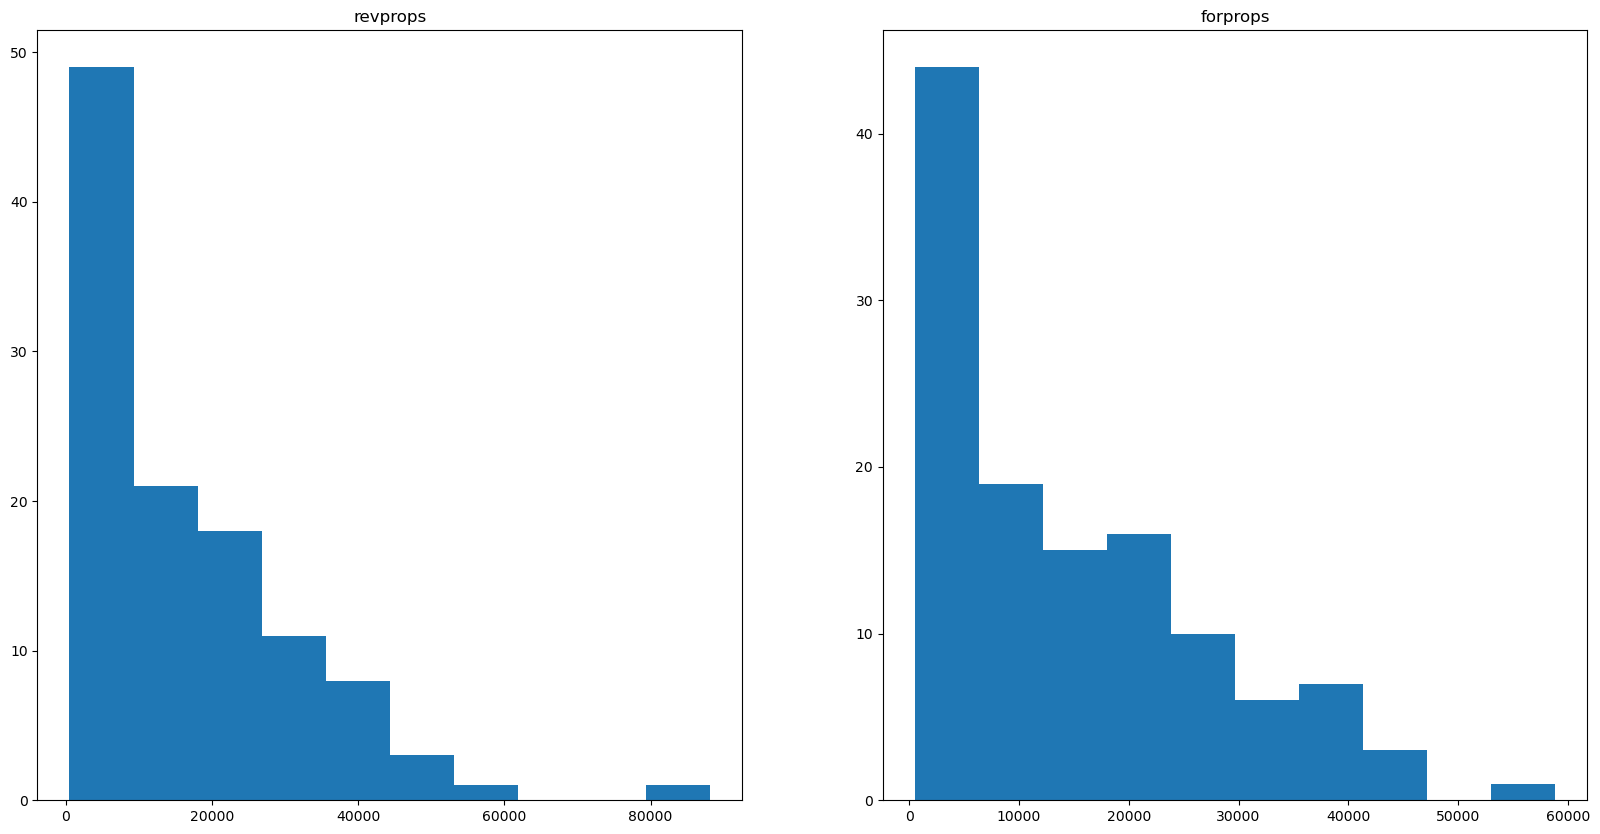

In [56]:

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].hist(revprops['area'])
ax[1].hist(forprops['area'])
ax[0].set_title('revprops')
ax[1].set_title('forprops')

# plt.hist(revprops['area'])

In [57]:
pal = sns.color_palette(cc.glasbey, n_colors=159, as_cmap=True)

In [58]:
matplotlib.colors.hex2color(pal[0])

(0.0, 0.0, 0.0)

## Make gifs of forward and reverse images

In [2]:
showtif(forims)

NameError: name 'showtif' is not defined

# Compare All Images in Dataset

## Create DF to capture output data.

### Compare version, count of cells, volume of cells.

In [59]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

# imgfolders

In [60]:
# Create reference df for all images
compdf = pd.DataFrame(imgfolders, columns=['img'])
compdf['labelpath']=''
compdf['track_version']=''
compdf['read_direction']=''
compdf['cell_count']=''
compdf['volume']=''

In [61]:
for index, row in compdf.iterrows():
    indir = os.path.join(DATADIR,compdf.iloc[index]['img'])
    compdf.at[index,'labelpath'] = os.path.join(indir,'label.tif')
    compdf.at[index,'track_version'] = [3,4]
    compdf.at[index,'read_direction'] = ['forward','reverse']
compdf[0:10]

,img,labelpath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,"[3, 4]","[forward, reverse]",,


In [62]:
compdf = compdf.explode('track_version').reset_index(drop=True)
compdf = compdf.explode('read_direction').reset_index(drop=True)
compdf[0:10]

,img,labelpath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,,
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,,
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,,
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,,
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,,
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,,
6,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,,
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,,
8,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,,
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,,


In [63]:
testgroup = compdf[0:4]
testgroup

,img,labelpath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,,
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,,
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,,
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,,


## Run Comparison

In [ ]:
# Test run the pipeline

# Loop to run single image through all
runtest = True
runtest = False

df = testgroup
df = compdf


start_time = time.time()
if runtest:
    for i in df.index:
        try:
            imagename = df['img'][i]
            labelimage = df['labelpath'][i]
            version = df['track_version'][i]
            direction = df['read_direction'][i]

            if direction == 'forward':
                labeldict = CreateLabelDictv02(labelimage)
            if direction == 'reverse':
                labeldict = CreateLabelDictv02(labelimage, reverse_direction = True)
            if version == 3:
                newlabels = CellTrackerv03(labeldict)
            if version == 4:
                newlabels = CellTrackerv04(labeldict)
            newstack = []
            for j in newlabels['labels']:
                newstack.append(newlabels['labels'][j])
            newims = np.stack(newstack)

            props = pd.DataFrame(measure.regionprops_table(newims, properties=('label','area')))

            df.at[i,'cell_count'] = len(props['label'])
            df.at[i,'volume'] = props['area'].mean()
        except:
            continue
print("--- %s seconds ---" % round((time.time() - start_time),0))

df

In [ ]:
savecsv = True
savecsv = False

if savecsv:
    df.to_csv(os.path.join(OUTDIR,"RunComps.csv"))

# Plotting

In [64]:
# Make plotting df
os.chdir(OUTDIR)
plotdf = pd.read_csv('RunComps.csv', index_col = 0)


In [65]:
# Make plotting df and remove imgs with any empty values.
emptyimgs = plotdf[plotdf['cell_count']=='']['img'].tolist()
plotdf = plotdf[plotdf['img'].isin(emptyimgs)==False].reset_index(drop=True)
emptyimgs

[]

In [64]:
plotdf.dropna()

,img,labelpath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,148.0,14403.020270
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,145.0,14701.013793
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,121.0,15046.644628
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,112.0,16255.750000
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,137.0,15501.795620
...,...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_22,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,88.0,14976.704545
88,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,107.0,16973.233645
89,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,104.0,17462.846154
90,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,88.0,18187.397727


In [66]:
plotdf.reset_index(drop=True)

,img,labelpath,track_version,read_direction,cell_count,volume
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,148.0,14403.020270
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,145.0,14701.013793
2,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,121.0,15046.644628
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,112.0,16255.750000
4,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,137.0,15501.795620
...,...,...,...,...,...,...
87,C1-FB323A_CSC_Rd1_22,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,reverse,88.0,14976.704545
88,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,forward,107.0,16973.233645
89,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,reverse,104.0,17462.846154
90,C1-FB323A_CSC_Rd1_23,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,forward,88.0,18187.397727


In [67]:
diffs = pd.pivot_table(plotdf,
                       index=['img','track_version'],
                       # columns = ['img','track_version'],
                       values = ['cell_count','volume'],
                       aggfunc = 'diff'
                       )
# diffs

In [68]:
aggdf = plotdf[plotdf.index.isin(diffs.index)]
aggdf = aggdf.drop(plotdf.columns[3:], axis=1)
aggdf = aggdf.join(diffs)

In [69]:
aggdf.volume = abs(aggdf.volume)
aggdf.cell_count = abs(aggdf.cell_count)

In [70]:
aggdf

,img,labelpath,track_version,cell_count,volume
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,3.0,297.993523
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,9.0,1209.105372
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,6.0,650.424991
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,2.0,295.830303
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,9.0,687.553571
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,9.0,743.440065
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,3.0,272.017093
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,3.0,349.931213
17,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,7.0,754.506767
19,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,9.0,1552.140659


In [71]:
cellchange = plotdf.cell_count.pct_change()
cellchange = cellchange[cellchange.index.isin(aggdf.index)]
aggdf = aggdf.join(cellchange,rsuffix='_pct')

volchange = plotdf.volume.pct_change()
volchange = volchange[volchange.index.isin(aggdf.index)]
aggdf = aggdf.join(volchange,rsuffix='_pct')

In [72]:
aggdf.cell_count_pct = abs(aggdf.cell_count_pct)
aggdf.volume_pct = abs(aggdf.volume_pct)

In [73]:
aggdf

,img,labelpath,track_version,cell_count,volume,cell_count_pct,volume_pct
1,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,3.0,297.993523,0.020270,0.020690
3,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,9.0,1209.105372,0.074380,0.080357
5,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,6.0,650.424991,0.043796,0.041958
7,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,2.0,295.830303,0.018519,0.018182
9,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,9.0,687.553571,0.050847,0.053571
11,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,9.0,743.440065,0.056962,0.060403
13,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,3.0,272.017093,0.019868,0.020270
15,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,3.0,349.931213,0.024000,0.024590
17,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,3,7.0,754.506767,0.050000,0.052632
19,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,4,9.0,1552.140659,0.089109,0.097826


## Difference Between Versions

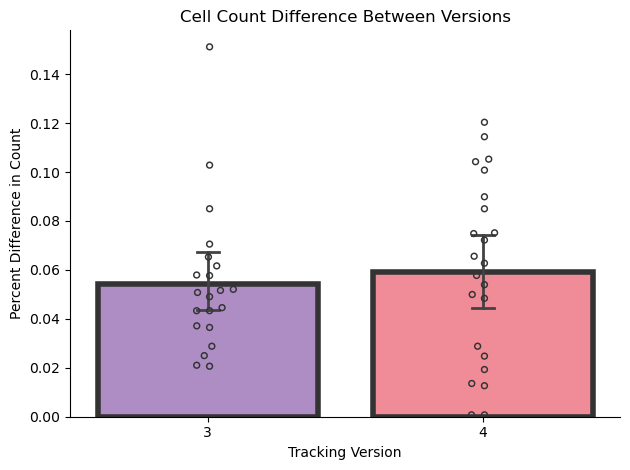

In [74]:
plt.style.use('default')

colors = ['#af84cd','#ff7b8b']

sns.barplot(x='track_version',
            y='cell_count_pct',
            data=aggdf,
            # fill=False,
            palette=colors,
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2"
            )
sns.swarmplot(x='track_version',
              y='cell_count_pct',
              data=aggdf,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",
              )

plt.xlabel("Tracking Version", size=10)
plt.ylabel("Percent Difference in Count", size=10)
plt.title("Cell Count Difference Between Versions", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

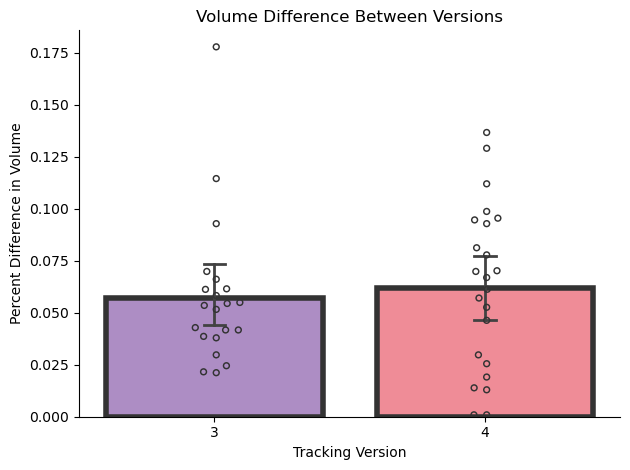

In [74]:
plt.style.use('default')

colors = ['#af84cd','#ff7b8b']

sns.barplot(x='track_version',
            y='volume_pct',
            data=aggdf,
            # fill=False,
            palette=colors,
            capsize=0.08,
            errwidth=2,
            linewidth = 4,
            edgecolor="0.2"
            )
sns.swarmplot(x='track_version',
              y='volume_pct',
              data=aggdf,
              # palette = colors,
              # palette = 'black',
              color = '0.2',
              s=8,
              marker="$\circ$",
              )

plt.xlabel("Tracking Version", size=10)
plt.ylabel("Percent Difference in Volume", size=10)
plt.title("Volume Difference Between Versions", size=12)
plt.xticks()
plt.yticks()
plt.tight_layout()

sns.despine()

## Difference within version

# Full Volume Images

In [60]:
testgroup = imgdf.iloc[[2]].copy()
# inputimg = testgroup['labelpath'][0]
testgroup.imgfolder

2    C1-FB323A_CSC_Rd1_3
Name: imgfolder, dtype: object

In [ ]:
# Loop to run single image through all
runtest = True # 72 seconds
# runtest = False

df = testgroup

start_time = time.time()
if runtest:
    for i in df.index:
        imagename = df['imgfolder'][i]
        labelimage = df['labelpath'][i]
        forwardlabeldict = CreateLabelDictv02(labelimage)
        reverselabeldict = CreateLabelDictv02(labelimage, reverse_direction = True)
        newlabelsforward = CellTrackerv04(forwardlabeldict)
        newlabelsreverse = CellTrackerv04(reverselabeldict)

print("--- %s seconds ---" % round((time.time() - start_time),0))

## Forward direction

In [ ]:
imstack = StackCreatorv01(newlabelsforward)

In [ ]:
dftoqc = newlabelsforward

uniquelabs=[]
for i in dftoqc['labels'].keys():
    for j in np.unique(dftoqc['labels'][i]):
        uniquelabs.append(j)
print(len(np.unique(uniquelabs)), np.max(uniquelabs))

uniqueprops = []
for i in dftoqc['props'].keys():
    for j in np.unique(dftoqc['props'][i].label):
        uniqueprops.append(j)
print(len(np.unique(uniqueprops)), np.max(uniqueprops))

Counter(uniqueprops) == Counter([value for value in uniquelabs if value != 0])

In [ ]:
# From stackcreator function. Creates a random color for each label that can be referenced throughout the stack. Format is in RGB (3 columns per label, each value is between 0 and 1).

uniquelabs = np.unique(uniquelabs)
# Create the color map for all of the unique labels.
randcols = np.random.random((len(uniquelabs), 3))
# Set background labels as 0
randcols[0] = 0
print(len(uniquelabs))
len(randcols)
# randcols

In [ ]:
pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
pal[0] = '#000000'
print(len(pal))
sns.palplot(pal)

In [ ]:
# Create a separate stack from just the label images (pull them from the dictionary)
newstack = []
for i in dftoqc['labels']:
    newstack.append(dftoqc['labels'][i])
forims = np.stack(newstack)
forims.shape
len(np.unique(forims))

In [ ]:
# Make a colormap for matplotlib from the random colors generated.
mycmap = matplotlib.colors.ListedColormap(pal) # randcols
mycmap

In [ ]:
# Convert the label colors to rgba values represented as hex codes (necessary for the ax3d to read them).
# Output is a list with each value being the hex code for the rgba value associated with the label, includes all values in the original image.

newcols = np.empty(uniquelabs.shape, dtype='<U9')
for i in uniquelabs:
    rgba = matplotlib.colors.rgb2hex(mycmap(i),keep_alpha=True)
    newcols = np.where(uniquelabs==i, rgba, newcols)
# newcols

In [ ]:
hexdict = {}
for idx,hex in enumerate(pal):
    hexdict[idx]=hex
# hexdict

In [ ]:
imtoshow = forims

rgbdict = {}
for col in hexdict.keys():
    rgbdict[col]=matplotlib.colors.hex2color(hexdict[col])

hstacks = []
for val in rgbdict.values():
    hstacks.append(np.hstack(val))
rgbstacks = np.stack(hstacks)

r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

for idx,red in enumerate(rgbstacks[:,0]):
    r = np.where(imtoshow==idx, red,r)
for idx,green in enumerate(rgbstacks[:,1]):
    g = np.where(imtoshow==idx, green,g)
for idx,blue in enumerate(rgbstacks[:,2]):
    b = np.where(imtoshow==idx, blue,b)

fullrgbim = np.stack((r,g,b), axis=3)

fullrgbim.shape

In [ ]:
# Take a small piece of the full image to make 3D (full image takes a very long time to create)

projectbw = forims.copy()
projectxydims = 300

x_min = np.random.randint(0,projectbw.shape[1]-projectxydims)
x_max = x_min + projectxydims
y_min = np.random.randint(0,projectbw.shape[2]-projectxydims)
y_max = y_min + projectxydims

# For Setting custom coordinates:
# y_min = 512
# y_max = 912
# x_min = 423
# x_max = 823
# dims 300
y_min = 481
y_max = 781
x_min = 358
x_max = 658

z_min = 0
z_max = projectbw.shape[0] + z_min
masks = projectbw[z_min:z_max, x_min:x_max, y_min:y_max]
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

print(plot_masks.shape)
print(y_min, y_max,x_min, x_max)

In [2]:
import matplotlib.patches as mpatches

ztoshow=0

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(fullrgbim[ztoshow],interpolation='nearest')
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_axis_off()

NameError: name 'plt' is not defined

Labels in stack 0: [ 0 35 36 40 42 47 48 52 56 60 63 64 67 68 69 70 73 74]
Labels in entire image: [  0  35  36  40  42  47  48  52  56  60  63  64  67  68  69  70  73  74
  76  82 115 146 147]


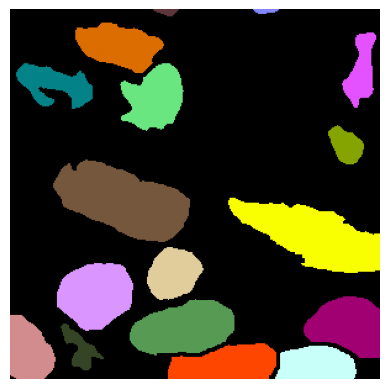

In [162]:
# imtoshow = forims

plt.imshow(fullrgbim[ztoshow,x_min:x_max,y_min:y_max])
plt.axis('off')
print(f'Labels in stack {ztoshow}: {np.unique(plot_masks[:,:,ztoshow])}')
print(f'Labels in entire image: {np.unique(plot_masks)}')

In [141]:
# # For spot checking against labels
# fig, ax = plt.subplots(1,2, figsize=(12, 6))
# ax[0].imshow(fullrgbim[ztoshow],interpolation='nearest')
# rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
# ax[0].add_patch(rect)
# ax[0].set_axis_off()
#
# # ax[1].add_patch(rect)
# rect2 = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
# ax[1].imshow(imstack['numbered'][ztoshow])
# ax[1].add_patch(rect2)
# ax[1].set_axis_off()
#
# plt.tight_layout()

In [142]:
# # Color checking a specific label
# import matplotlib.patches as mpatches
#
# labid = 61
# someX, someY = 0.5, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(mpatches.Rectangle((someX - 0.1, someY - 0.1), 0.2, 0.2,
#                                 alpha=1, facecolor=matplotlib.colors.to_rgba(hexdict[labid])))

### Create Volumetric Image

--- 138.0 seconds ---


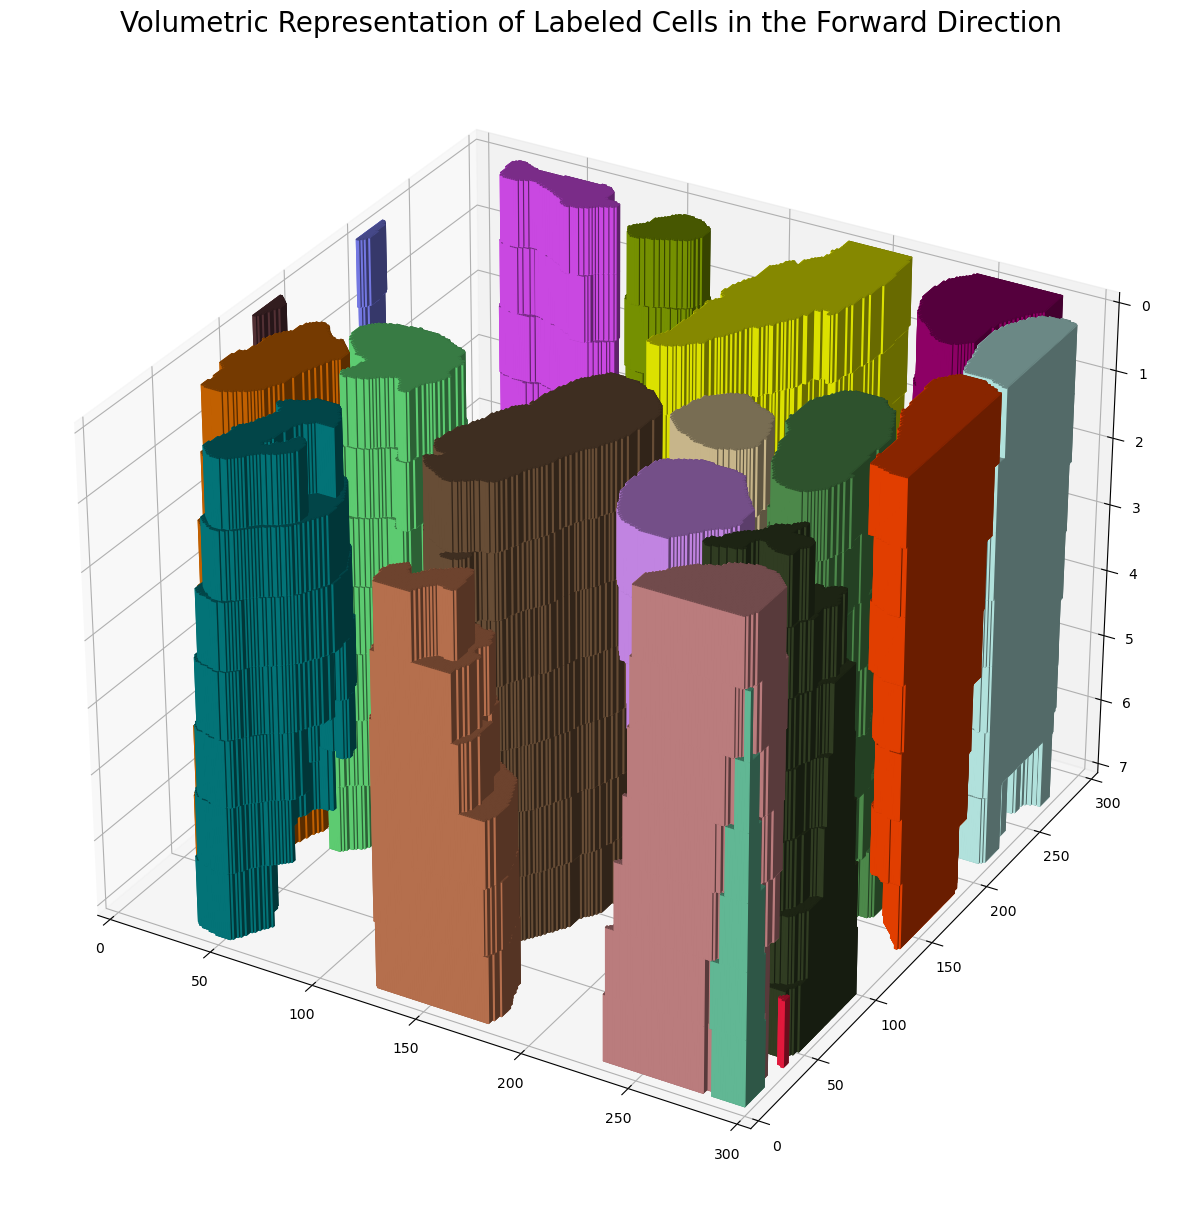

In [163]:
# at this point: newcols is the list of colors as hex labels, plot_masks is the image to plot with the labels as numbers.
# Need to make a 3dimensional map of the colors using the labels being plotted to pass to the volumetric plotting.
# Need to set none for background images.

ndcolstopass = np.empty(plot_masks.shape, dtype='<U9')

for label, i in enumerate(newcols):
    if label in plot_masks:
        # print(f"Label: {label}, RGBA Hex: {i}")
        if label==0:
            voxcol = None
        else:
            voxcol = i
        ndcolstopass = np.where(plot_masks==label, voxcol,ndcolstopass)

start_time = time.time()

fig = plt.figure(figsize=(15, 25))

# Predicted Cell volumes
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, projectxydims)
ax.set_ylim3d(0, projectxydims)
ax.set_zlim3d(z_max, z_min)

ax.voxels(plot_masks,
          facecolors=ndcolstopass,
          edgecolors=ndcolstopass,
          )
ax.set_title('Volumetric Representation of Labeled Cells in the Forward Direction', fontsize = 20)
print("--- %s seconds ---" % round((time.time() - start_time),0))
plt.show()

## Reverse Direction

In [164]:
imstack = StackCreatorv01(newlabelsreverse)

In [165]:
dftoqc = newlabelsreverse

uniquelabs=[]
for i in dftoqc['labels'].keys():
    for j in np.unique(dftoqc['labels'][i]):
        uniquelabs.append(j)
print(len(np.unique(uniquelabs)), np.max(uniquelabs))

uniqueprops = []
for i in dftoqc['props'].keys():
    for j in np.unique(dftoqc['props'][i].label):
        uniqueprops.append(j)
print(len(np.unique(uniqueprops)), np.max(uniqueprops))

Counter(uniqueprops) == Counter([value for value in uniquelabs if value != 0])

150 149
149 149


False

In [166]:
# From stackcreator function. Creates a random color for each label that can be referenced throughout the stack. Format is in RGB (3 columns per label, each value is between 0 and 1).

uniquelabs = np.unique(uniquelabs)

# # Create the color map for all of the unique labels.
# randcols = np.random.random((len(uniquelabs), 3))
# # Set background labels as 0
# randcols[0] = 0
# print(len(uniquelabs))
# len(randcols)
# # randcols

256


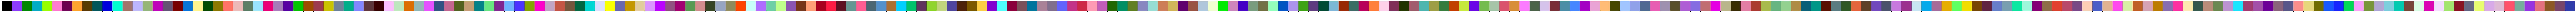

In [167]:
pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
pal[0] = '#000000'
print(len(pal))
sns.palplot(pal)

In [168]:
# Create a separate stack from just the label images (pull them from the dictionary)
newstack = []
for i in dftoqc['labels']:
    newstack.append(dftoqc['labels'][i])
revims = np.stack(newstack)
revims.shape
len(np.unique(revims))

150

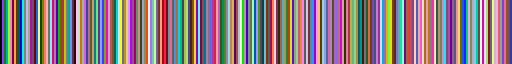

In [169]:
# Make a colormap for matplotlib from the random colors generated.
mycmap = matplotlib.colors.ListedColormap(pal) # randcols
mycmap

In [170]:
# Convert the label colors to rgba values represented as hex codes (necessary for the ax3d to read them).
# Output is a list with each value being the hex code for the rgba value associated with the label, includes all values in the original image.

newcols = np.empty(uniquelabs.shape, dtype='<U9')
for i in uniquelabs:
    rgba = matplotlib.colors.rgb2hex(mycmap(i),keep_alpha=True)
    newcols = np.where(uniquelabs==i, rgba, newcols)
# newcols

In [171]:
hexdict = {}
for idx,hex in enumerate(pal):
    hexdict[idx]=hex
# hexdict

In [172]:
imtoshow = revims

rgbdict = {}
for col in hexdict.keys():
    rgbdict[col]=matplotlib.colors.hex2color(hexdict[col])

hstacks = []
for val in rgbdict.values():
    hstacks.append(np.hstack(val))
rgbstacks = np.stack(hstacks)

r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

for idx,red in enumerate(rgbstacks[:,0]):
    r = np.where(imtoshow==idx, red,r)
for idx,green in enumerate(rgbstacks[:,1]):
    g = np.where(imtoshow==idx, green,g)
for idx,blue in enumerate(rgbstacks[:,2]):
    b = np.where(imtoshow==idx, blue,b)

fullrgbim = np.stack((r,g,b), axis=3)

fullrgbim.shape

(7, 1024, 1024, 3)

In [173]:
# Take a small piece of the full image to make 3D (full image takes a very long time to create)

projectbw = revims.copy()
projectxydims = 300

x_min = np.random.randint(0,projectbw.shape[1]-projectxydims)
x_max = x_min + projectxydims
y_min = np.random.randint(0,projectbw.shape[2]-projectxydims)
y_max = y_min + projectxydims

# For Setting custom coordinates:
# y_min = 512
# y_max = 912
# x_min = 423
# x_max = 823
# dims 300
y_min = 481
y_max = 781
x_min = 358
x_max = 658

z_min = 0
z_max = projectbw.shape[0] + z_min
masks = projectbw[z_min:z_max, x_min:x_max, y_min:y_max]
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

print(plot_masks.shape)
print(y_min, y_max,x_min, x_max)

(300, 300, 7)
481 781 358 658


In [174]:
import matplotlib.patches as mpatches

ztoshow=0

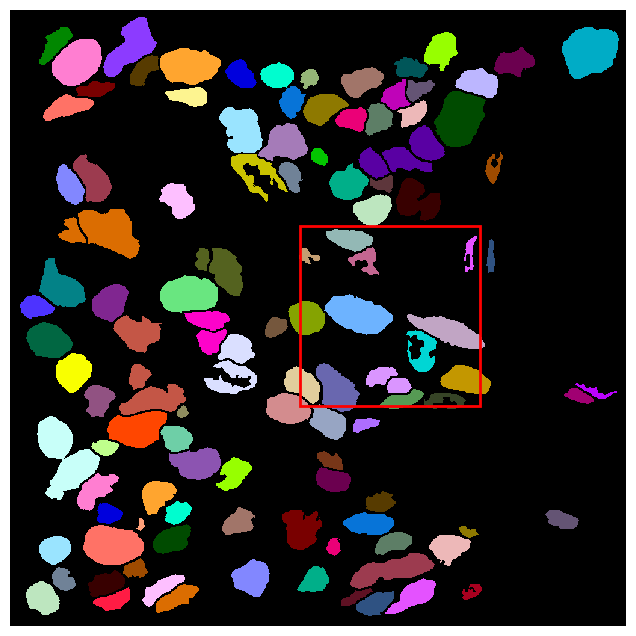

In [175]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(fullrgbim[ztoshow],interpolation='nearest')
# ax[0].imshow(color.label2rgb(imtoshow[ztoshow], colors = randcols, bg_label=0))
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
ax.set_axis_off()

Labels in stack 0: [ 0 39 41 42 44 46 50 52 54 58 61 62 63 64 68 69 70 71]
Labels in entire image: [  0  39  41  42  44  46  50  52  54  58  61  62  63  64  68  69  70  71
  85  87  90  91 117]


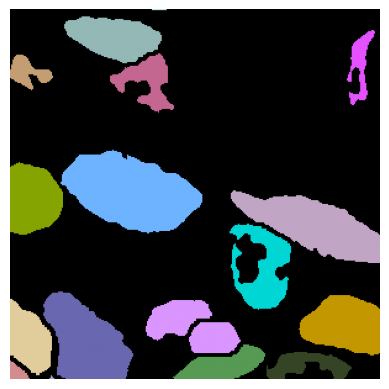

In [176]:
# imtoshow = revims

plt.imshow(fullrgbim[ztoshow,x_min:x_max,y_min:y_max])
plt.axis('off')
print(f'Labels in stack {ztoshow}: {np.unique(plot_masks[:,:,ztoshow])}')
print(f'Labels in entire image: {np.unique(plot_masks)}')

In [323]:
# # For spot checking against labels
# fig, ax = plt.subplots(1,2, figsize=(12, 6))
# ax[0].imshow(fullrgbim[ztoshow],interpolation='nearest')
# # ax[0].imshow(color.label2rgb(imtoshow[ztoshow], colors = randcols, bg_label=0))
# rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
# ax[0].add_patch(rect)
# ax[0].set_axis_off()
#
# # ax[1].add_patch(rect)
# rect2 = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
# ax[1].imshow(imstack['numbered'][ztoshow])
# ax[1].add_patch(rect2)
# ax[1].set_axis_off()
#
# plt.tight_layout()

In [324]:
# # Color checking a specific label
# import matplotlib.patches as mpatches
#
# labid = 61
# someX, someY = 0.5, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(mpatches.Rectangle((someX - 0.1, someY - 0.1), 0.2, 0.2,
#                                 alpha=1, facecolor=matplotlib.colors.to_rgba(hexdict[labid])))

### Create Volumetric Image

--- 142.0 seconds ---


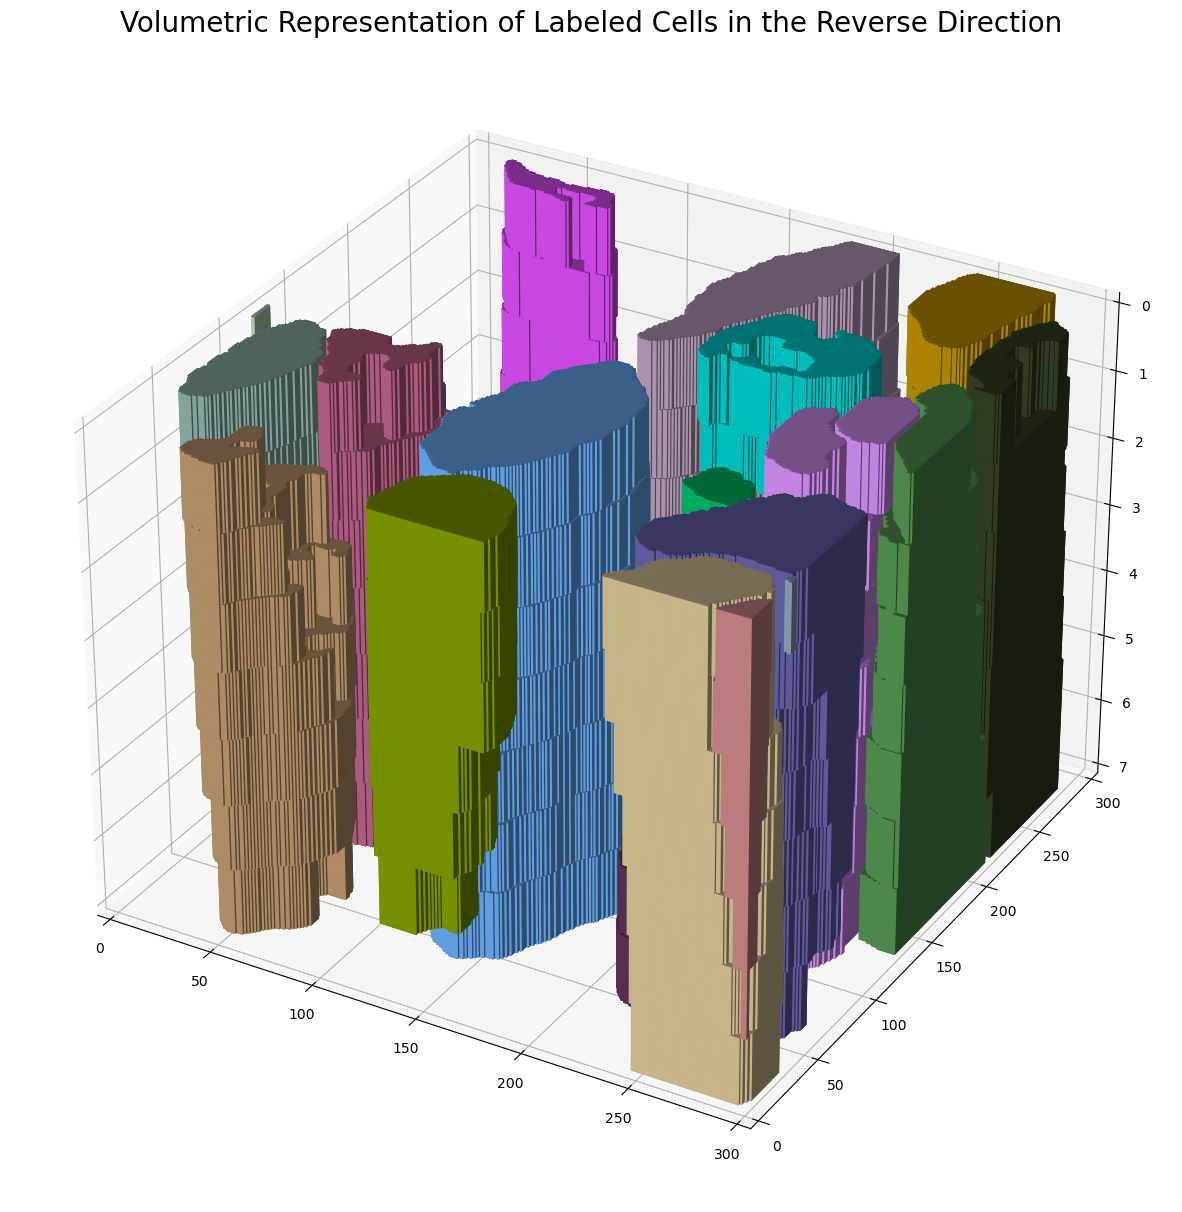

In [177]:
# at this point: newcols is the list of colors as hex labels, plot_masks is the image to plot with the labels as numbers.
# Need to make a 3dimensional map of the colors using the labels being plotted to pass to the volumetric plotting.
# Need to set none for background images.

ndcolstopass = np.empty(plot_masks.shape, dtype='<U9')

for label, i in enumerate(newcols):
    if label in plot_masks:
        # print(f"Label: {label}, RGBA Hex: {i}")
        if label==0:
            voxcol = None
        else:
            voxcol = i
        ndcolstopass = np.where(plot_masks==label, voxcol,ndcolstopass)

start_time = time.time()

fig = plt.figure(figsize=(15, 25))

# Predicted Cell volumes
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, projectxydims)
ax.set_ylim3d(0, projectxydims)
ax.set_zlim3d(z_max, z_min)

ax.voxels(plot_masks,
          facecolors=ndcolstopass,
          edgecolors=ndcolstopass,
          )
ax.set_title('Volumetric Representation of Labeled Cells in the Reverse Direction', fontsize = 20)
print("--- %s seconds ---" % round((time.time() - start_time),0))
plt.show()

# Testing